In [ ]:
import torch
import random

def load_simulation_for_krr(filepath, num_samples=1000):
    with open(filepath, "r") as f:
        lines = f.readlines()

    header = lines[0].strip().split()
    assert header[0] == "Simulation", "Unexpected file format"

    W, H = int(header[2]), int(header[3])
    charges = []
    for i in range(4):
        x = int(header[4 + i * 3])
        y = int(header[5 + i * 3])
        q = float(header[6 + i * 3])
        charges.extend([x, y, q])

    charge_tensor = torch.tensor(charges, dtype=torch.float32)

    grid_lines = lines[2:]
    grid = []
    for line in grid_lines:
        row = list(map(float, line.strip().split()))
        if row:
            grid.append(row)

    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    grid_tensor = grid_tensor[1:-1, 1:-1]
    assert grid_tensor.shape == (1000, 1000)

    coords = [(i, j) for i in range(1000) for j in range(1000)]
    sampled_coords = random.sample(coords, num_samples)

    X_train = []
    y_train = []
    for y, x in sampled_coords:
        X_train.append([x, y] + charges)
        y_train.append(grid_tensor[y, x].item())

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)

    X_test = []
    for y in range(1000):
        for x in range(1000):
            X_test.append([x, y] + charges)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    return X_train, y_train, X_test, grid_tensor

In [ ]:
import gpytorch

X_train, y_train, X_test, grid_true = load_simulation_for_krr("generated_data/simulation_53.txt")

print("Train X shape:", X_train.shape)  # torch.Size([1000, 14])
print("Train y shape:", y_train.shape)  # torch.Size([1000])
print("Test X shape:", X_test.shape)    # torch.Size([1000000, 14])
print("True grid shape:", grid_true.shape)  # torch.Size([1000, 1000])
print("\n")

# Normalization
X_mean = X_train.mean(dim=0, keepdim=True)
X_std = X_train.std(dim=0, keepdim=True)
X_std[X_std == 0] = 1.0

X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

y_mean = y_train.mean()
y_std = y_train.std()
if y_std == 0:
    y_std = 1.0

y_train_norm = (y_train - y_mean) / y_std

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_norm, y_train_norm, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train_norm)
    loss = -mll(output, y_train_norm)
    loss.backward()
    if i % 10 == 0:
        print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}")
    optimizer.step()

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = likelihood(model(X_test_norm))
    mean_pred = pred_dist.mean
    lower, upper = pred_dist.confidence_region()

# Un-normalize predictions
mean_pred_orig = mean_pred * y_std + y_mean

print("Predicted shape:", mean_pred_orig.shape)

Train X shape: torch.Size([1000, 14])
Train y shape: torch.Size([1000])
Test X shape: torch.Size([1000000, 14])
True grid shape: torch.Size([1000, 1000])
Iter 1/100 - Loss: 0.840
Iter 11/100 - Loss: 0.466
Iter 21/100 - Loss: 0.067
Iter 31/100 - Loss: -0.326
Iter 41/100 - Loss: -0.579
Iter 51/100 - Loss: -0.696
Iter 61/100 - Loss: -0.753
Iter 71/100 - Loss: -0.737
Iter 81/100 - Loss: -0.763
Iter 91/100 - Loss: -0.760
Predicted shape: torch.Size([1000000])


In [45]:
import torch.nn.functional as F

pred_grid = mean_pred_orig.reshape(1000, 1000)

mae = torch.mean(torch.abs(pred_grid - grid_true))
mse = torch.mean((pred_grid - grid_true) ** 2)
rmse = torch.sqrt(mse)

print(f"MAE: {mae.item():.4f}")
print(f"MSE: {mse.item():.4f}")
print(f"RMSE: {rmse.item():.4f}")

MAE: 0.1050
MSE: 0.1327
RMSE: 0.3643


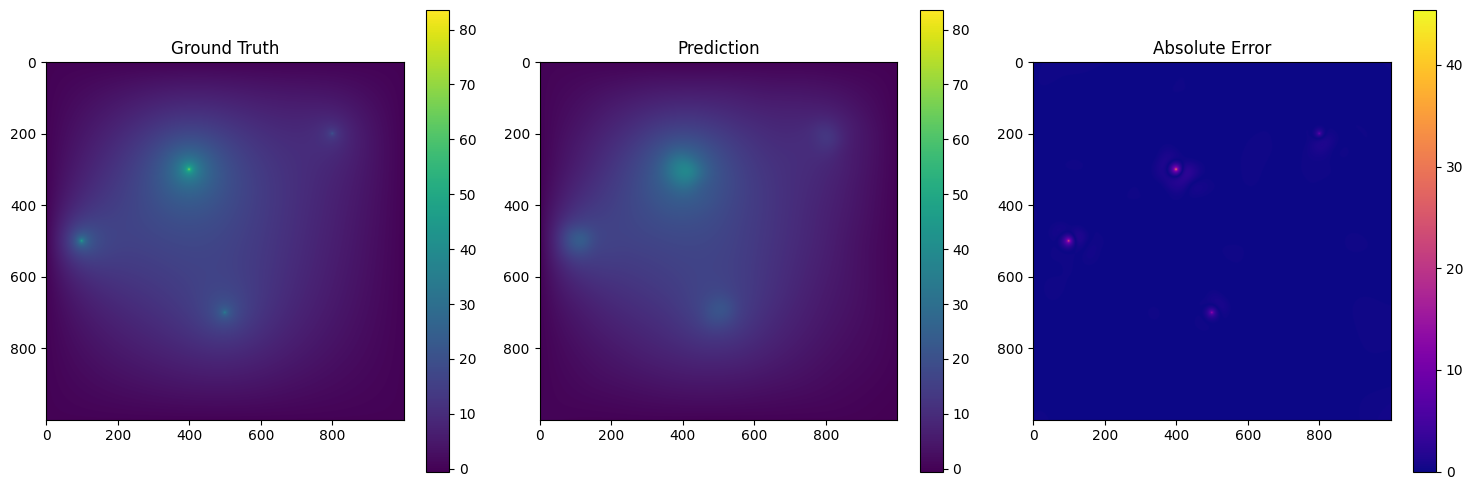

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

gt = grid_true.numpy()
pred = pred_grid.detach().numpy()
error = np.abs(pred - gt)

vmin = min(gt.min(), pred.min())
vmax = max(gt.max(), pred.max())

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Ground Truth")
im1 = plt.imshow(gt, vmin=vmin, vmax=vmax)
plt.colorbar(im1)

plt.subplot(1, 3, 2)
plt.title("Prediction")
im2 = plt.imshow(pred, vmin=vmin, vmax=vmax)
plt.colorbar(im2)

plt.subplot(1, 3, 3)
plt.title("Absolute Error")
im3 = plt.imshow(error, cmap='plasma')
plt.colorbar(im3)

plt.tight_layout()
plt.show()